# LSTMs

## Imports

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import linregress

## Data Generation

In [216]:
def plot_graph(x, y, no_fit=False):
    plt.plot(x, y, 'b')

    if no_fit == False:
        fit = linregress(x, y)
        fit_line = fit.slope * x + fit.intercept
        plt.plot(x, fit_line, 'r', linestyle='--')

    plt.ylabel('Graph')
    plt.xlabel('Time')
    plt.grid(True)
    plt.legend(['Graph', 'Fit(Trend)'])
    plt.show()

def multi_plot_graph(x, ys):
    for y in ys:
        plt.plot(x, y)

    plt.grid(True)
    plt.show()

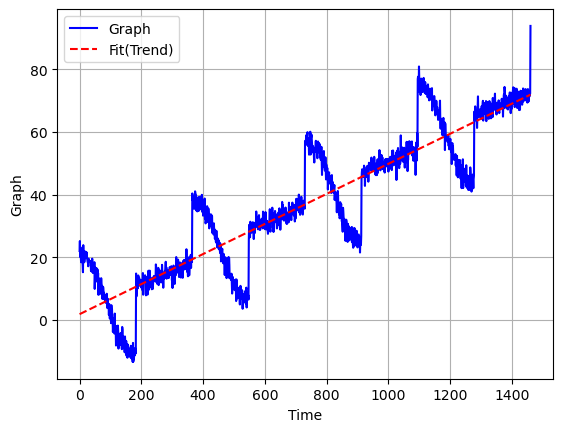

In [217]:
def Trend(time, slope):
    return time * slope

def Seasonality(time, period):
    time = (time % period) / period
    return np.where(time < 0.5, np.cos(2 * np.pi * time), 1 / np.exp(5 * time))

def Noise(time, amplitude):
    return amplitude * np.random.randn(len(time))

t = np.arange(0, 4 * 365 + 1, 1)
signal = Trend(t, 0.05) + 20 * Seasonality(t, 365) + Noise(t, 2)

plot_graph(t, signal)

## Dataset Generation

In [218]:
SPLIT_TIME = 3 * 365
train_data = signal[:SPLIT_TIME]
train_time = t[:SPLIT_TIME]
val_data = signal[SPLIT_TIME:]
val_time = t[SPLIT_TIME:]

In [219]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
LSTM_UNITS = 40
EPOCHS = 400

In [220]:
train_set = tf.data.Dataset.from_tensor_slices(train_data)
# Windowing
train_set = train_set.window(WINDOW_SIZE + 1, drop_remainder=True)
# Flattening
train_set = train_set.flat_map(lambda w: w.batch(WINDOW_SIZE + 1))
# Splitting
train_set = train_set.map(lambda x: (x[:-1], x[-1]))
# Shuffling
train_set = train_set.shuffle(SPLIT_TIME)
# Batching & Prefetching
train_set = train_set.batch(BATCH_SIZE).prefetch(2)

In [221]:
val_set = tf.data.Dataset.from_tensor_slices(val_data)

val_set = val_set.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
val_set = val_set.flat_map(lambda w: w.batch(WINDOW_SIZE + 1))
val_set = val_set.map(lambda x: (x[:-1], x[-1]))
val_set = val_set.shuffle(len(val_data))
val_set = val_set.batch(BATCH_SIZE).prefetch(2)

In [222]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda

def create_model():
    return Sequential([
        Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=(WINDOW_SIZE,)),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
        Bidirectional(LSTM(LSTM_UNITS)),
        Dense(1),
        Lambda(lambda x: x * 100)
    ])

In [223]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

model = create_model()
model.compile(
    optimizer=SGD(momentum=0.9),
    loss=Huber()
)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_32 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_32 (Bidirect  (None, 20, 80)            13440     
 ional)                                                          
                                                                 
 bidirectional_33 (Bidirect  (None, 80)                38720     
 ional)                                                          
                                                                 
 dense_16 (Dense)            (None, 1)                 81        
                                                                 
 lambda_33 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 52241 (204.07 KB)
Trainable params: 522

In [224]:
from tensorflow.keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 80))

In [225]:
hist = model.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[lr_scheduler])

Epoch 1/400


2/2 [==============================] - 4s 774ms/step - loss: 52.5489 - val_loss: 80.8351 - lr: 1.0000e-08
Epoch 2/400
2/2 [==============================] - 0s 53ms/step - loss: 52.5404 - val_loss: 80.8190 - lr: 1.0292e-08
Epoch 3/400
2/2 [==============================] - 0s 51ms/step - loss: 52.5241 - val_loss: 80.7957 - lr: 1.0593e-08
Epoch 4/400
2/2 [==============================] - 0s 51ms/step - loss: 52.5011 - val_loss: 80.7660 - lr: 1.0902e-08
Epoch 5/400
2/2 [==============================] - 0s 51ms/step - loss: 52.4730 - val_loss: 80.7307 - lr: 1.1220e-08
Epoch 6/400
2/2 [==============================] - 0s 51ms/step - loss: 52.4402 - val_loss: 80.6906 - lr: 1.1548e-08
Epoch 7/400
2/2 [==============================] - 0s 52ms/step - loss: 52.4021 - val_loss: 80.6466 - lr: 1.1885e-08
Epoch 8/400
2/2 [==============================] - 0s 51ms/step - loss: 52.3613 - val_loss: 80.5989 - lr: 1.2232e-08
Epoch 9/400
2/2 [==============================] - 0s 51ms/step - loss: 52.

## Plotting data

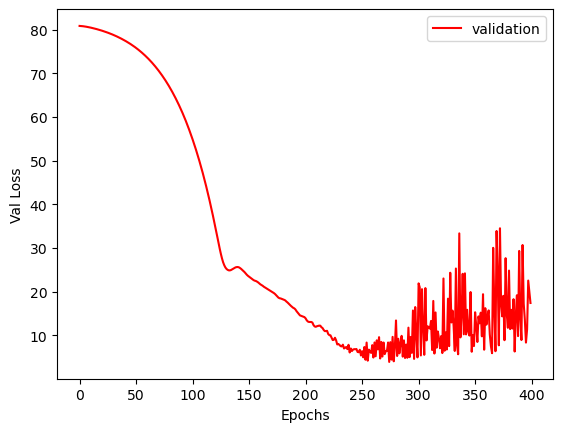

In [226]:
plt.plot(hist.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.legend(['validation'])
plt.show()

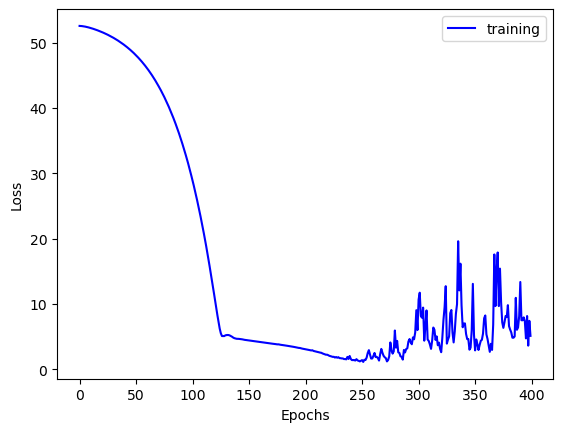

In [227]:
plt.plot(hist.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training'])
plt.show()

Text(0, 0.5, 'Loss')

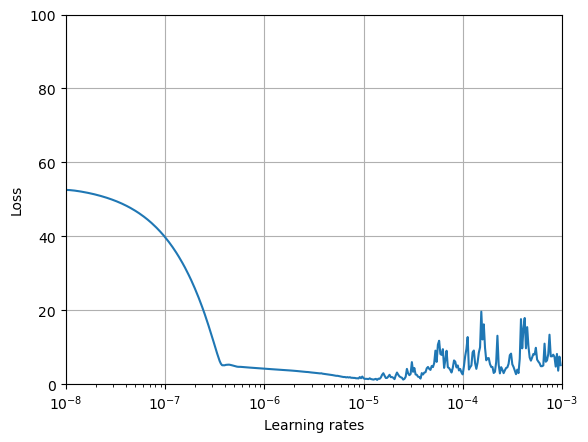

In [228]:
lrate = 1e-8 * 10 ** (np.arange(EPOCHS) / 80)
plt.semilogx(lrate, hist.history['loss'])
plt.axis([1e-8, 1e-3, 0, 100])
plt.grid(True)
plt.xlabel('Learning rates')
plt.ylabel('Loss')

In [229]:
min_loss = np.min(hist.history['loss'])
best_epoch = np.argmin(hist.history['loss'])
best_lr = hist.history['lr'][best_epoch]

print('MIN LOSS', min_loss)
print('BEST LR', best_lr)
print('BEST EPOCH', best_epoch)

MIN LOSS 1.1452311277389526
BEST LR 1.372461e-05
BEST EPOCH 251


## Ideal Model

In [230]:
model2 = create_model()
model2.compile(
    optimizer=SGD(learning_rate=best_lr, momentum=0.9),
    loss=Huber(),
    metrics=['mae']
)
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_34 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_34 (Bidirect  (None, 20, 80)            13440     
 ional)                                                          
                                                                 
 bidirectional_35 (Bidirect  (None, 80)                38720     
 ional)                                                          
                                                                 
 dense_17 (Dense)            (None, 1)                 81        
                                                                 
 lambda_35 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 52241 (204.07 KB)
Trainable params: 522

In [231]:
hist2 = model2.fit(train_set, epochs=best_epoch+1)

Epoch 1/252
2/2 [==============================] - 3s 41ms/step - loss: 10.5048 - mae: 11.0018
Epoch 2/252
2/2 [==============================] - 0s 9ms/step - loss: 7.6904 - mae: 8.1833
Epoch 3/252
2/2 [==============================] - 0s 7ms/step - loss: 5.4045 - mae: 5.8870
Epoch 4/252
2/2 [==============================] - 0s 7ms/step - loss: 4.2640 - mae: 4.7600
Epoch 5/252
2/2 [==============================] - 0s 7ms/step - loss: 4.4447 - mae: 4.9362
Epoch 6/252
2/2 [==============================] - 0s 7ms/step - loss: 9.6337 - mae: 10.1337
Epoch 7/252
2/2 [==============================] - 0s 7ms/step - loss: 5.1004 - mae: 5.5853
Epoch 8/252
2/2 [==============================] - 0s 7ms/step - loss: 6.4662 - mae: 6.9543
Epoch 9/252
2/2 [==============================] - 0s 7ms/step - loss: 5.3727 - mae: 5.8618
Epoch 10/252
2/2 [==============================] - 0s 8ms/step - loss: 4.4248 - mae: 4.9024
Epoch 11/252
2/2 [==============================] - 0s 7ms/step - loss: 6.8

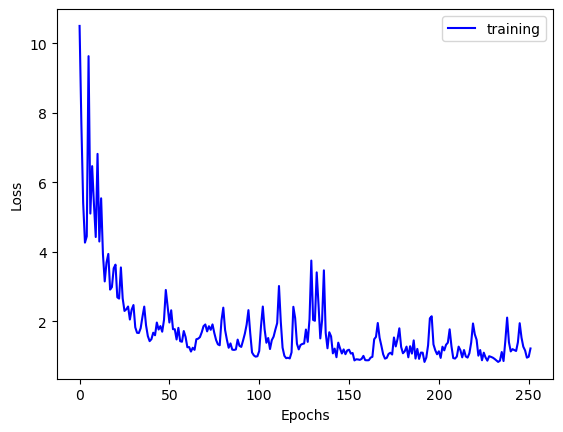

In [232]:
plt.plot(hist2.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training'])
plt.show()

In [233]:
series = signal[SPLIT_TIME - WINDOW_SIZE: -1]
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(WINDOW_SIZE, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda w: w.batch(WINDOW_SIZE))
dataset = dataset.batch(BATCH_SIZE).prefetch(2)

In [234]:
prediction = model2.predict(dataset)
prediction = prediction.squeeze()
print(prediction.shape)

12/12 [==============================] - 1s 3ms/step
(366,)


In [235]:
print(len(val_time))
print(len(val_data))

366
366


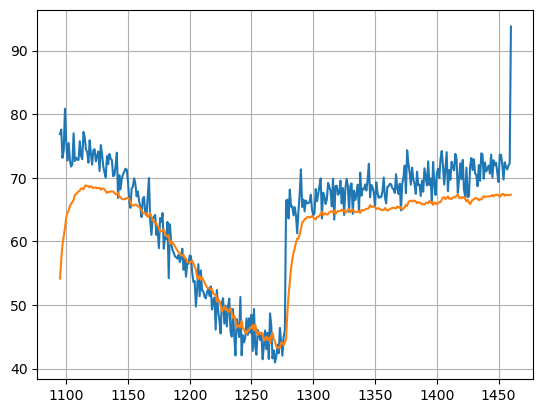

In [236]:
multi_plot_graph(val_time, (val_data, prediction))